In [93]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [155]:
# general settings for signal and noise
sample_freq = 1e6  # in Hz
length = 0.1  # in s
signal_power = 1.0  # in dB
noise_power = 0.0  # in dB

# create the signal (the 'soft speaker' kind)
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=None)
sig = wm.soft(f_center=-1e5, power=signal_power, dB=True)
sig += wm.soft(f_center=-2e5, power=signal_power+2, dB=True)
sig += wm.soft(f_center=1e5, power=signal_power-3, dB=True)
sig += wm.soft(f_center=2e5, power=signal_power+3, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length, seed=None)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise
both = noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Signal power: 8.06 dB
Noise power:  0.01 dB
SNR:          8.05 dB
Num samples:  100000


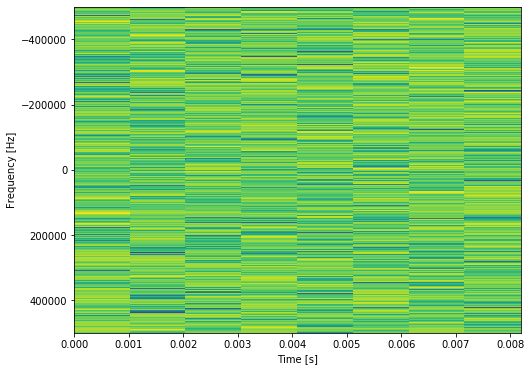

In [135]:
# use the 2d plot function to plot the spectogram
ss.spectrum_plot_2d(sig=both,
                    f_sample=sample_freq,
                    window='flattop',
                    nfft=1024)

100%|██████████| 99000/99000 [12:11<00:00, 135.30it/s]


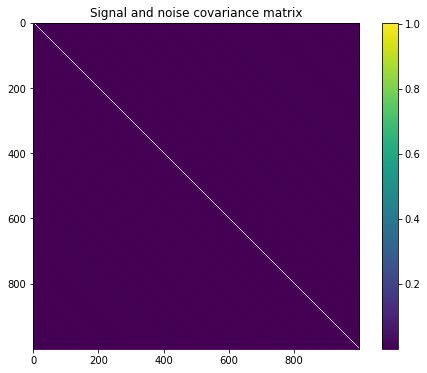

In [156]:
# covariance matrices
cov_size = 1000

# plt.figure(figsize=(8, 6))
# mat_noise = ss.eigen_detector.corr(x=noise, l=cov_size)
# plt.imshow(np.abs(mat_noise))
# plt.colorbar()
# plt.title('Noise only covariance matrix')
# plt.show()

# plt.figure(figsize=(8, 6))
# mat_sig = ss.eigen_detector.corr(x=sig, l=cov_size)
# plt.imshow(np.abs(mat_sig))
# plt.colorbar()
# plt.title('Signal only covariance matrix')
# plt.show()

plt.figure(figsize=(8, 6))
mat_both = ss.eigen_detector.corr(x=both, l=cov_size)
plt.imshow(np.abs(mat_both))
plt.colorbar()
plt.title('Signal and noise covariance matrix')
plt.show()

[1.34578926 1.34051151 1.31992569 1.28975168 1.27055541 1.26534388
 1.26170558 1.25684611 1.25600026 1.25398752 1.25125249 1.25021167
 1.24820183 1.24239056 1.23433939 1.23243594 1.23024152 1.22746211
 1.22708779 1.223771   1.22314676 1.22176709 1.21813302 1.21542997
 1.21395682 1.21305816 1.2125486  1.21146345 1.20952377 1.20484713
 1.20170658 1.20053466 1.19961627 1.19876518 1.19741962 1.19606158
 1.1940161  1.19371746 1.19202302 1.19009173 1.18864825 1.18816262
 1.18598483 1.18277453 1.18159571 1.18016555 1.17948636 1.17834657
 1.17790366 1.17667803 1.17632101 1.17452056 1.17241368 1.17096335
 1.16853059 1.16769006 1.16733782 1.16687851 1.16506833 1.16457047
 1.16403696 1.16376336 1.16240807 1.16040132 1.15961321 1.15886549
 1.15813043 1.15744793 1.15621536 1.15603374 1.1558291  1.15440242
 1.15391226 1.15189025 1.15060241 1.15036049 1.15022668 1.14962568
 1.14922702 1.14818743 1.14763601 1.14733374 1.14672256 1.1463468
 1.14589054 1.14568309 1.14484874 1.14447489 1.1439689  1.14390

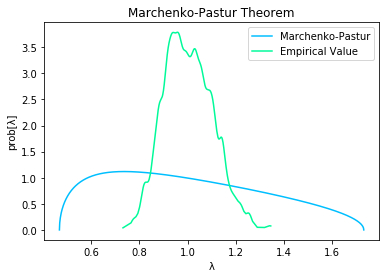

In [157]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity


def mpPDF(var, q, pts):
    """
    Creates a Marchenko-Pastur Probability Density Function
    Args:
        var (float): Variance
        q (float): T/N where T is the number of rows and N the number of columns
        pts (int): Number of points used to construct the PDF
    Returns:
        pd.Series: Marchenko-Pastur PDF
    """
    # Marchenko-Pastur pdf
    # q=T/N
    # Adjusting code to work with 1 dimension arrays
    if isinstance(var, np.ndarray):
        if var.shape == (1,):
            var = var[0]
    eMin, eMax = var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** .5
    pdf = pd.Series(pdf, index=eVal)
    return pdf


def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    """
    Fit kernel to a series of obs, and derive the prob of obs x is the array of values
        on which the fit KDE will be evaluated. It is the empirical PDF
    Args:
        obs (np.ndarray): observations to fit. Commonly is the diagonal of Eigenvalues
        bWidth (float): The bandwidth of the kernel. Default is .25
        kernel (str): The kernel to use. Valid kernels are [‘gaussian’|’tophat’|
            ’epanechnikov’|’exponential’|’linear’|’cosine’] Default is ‘gaussian’.
        x (np.ndarray): x is the array of values on which the fit KDE will be evaluated
    Returns:
        pd.Series: Empirical PDF
    """
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)  # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

both_eig_vals = np.sort(np.abs(linalg.eigvals(mat_both)))[::-1]
# Marchenko-Pastur pdf
pdf0 = mpPDF(1., q=10, pts=1000)
# Empirical pdf
pdf1= fitKDE(both_eig_vals, bWidth=0.01)

# Plotting results
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue")
pdf1.plot(label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")

print(both_eig_vals)

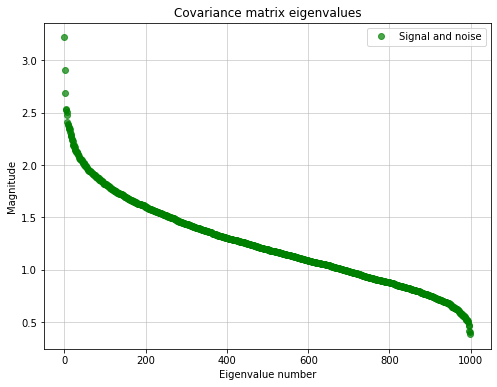

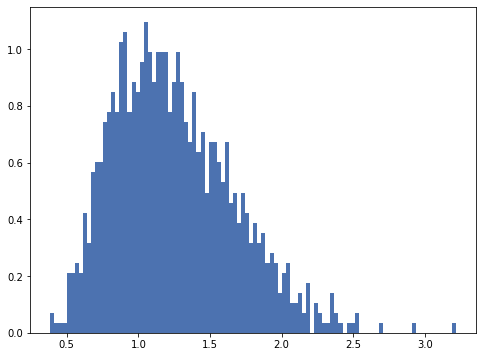

In [145]:
# plot eigenvalue distribution

# calculate eigenvalues
# noise_eig_vals = np.abs(linalg.eigvals(mat_noise))
both_eig_vals = np.sort(np.abs(linalg.eigvals(mat_both)))[::-1]

# and plot them together in one graph
plt.figure(figsize=(8, 6))
# plt.plot(noise_eig_vals, 'ro', alpha=0.7, aa=True, label='Noise only')
plt.plot(both_eig_vals, 'go', alpha=0.7, aa=True, label='Signal and noise')
plt.xlabel(r'Eigenvalue number')
plt.ylabel(r'Magnitude')
plt.grid(linewidth=0.5)
plt.title('Covariance matrix eigenvalues')
plt.legend(loc=0)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(both_eig_vals, bins=100, density=True,)
plt.show()



/home/fabian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


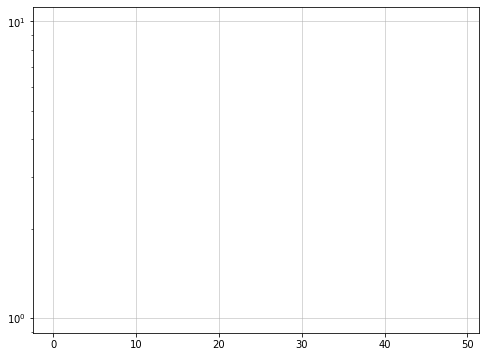

optM 49
act 31.622776601683793
est 1.1964621221026928


In [146]:
# L - total matrix size
# M - number of signal eigenvalues
# N - number of samples
# eigs - list of sorted eigenvalues


def mdl(L, N, eigs, M):
    eigs = eigs[M:]
    prod = np.prod(eigs**(1 / (L - M)))
    summ = np.sum(eigs) / (L - M)
    return -(L - M) * N * np.log(
        prod / summ) + .5 * M * (2 * L - M) * np.log(N)

x = list(range(1000))
y = list(map(lambda x: mdl(50, 1e6, both_eig_vals, x), x))

plt.figure(figsize=(8, 6))
plt.plot(y, 'go')
plt.grid(linewidth=0.5)
plt.yscale('log')
plt.show()

M = np.argmin(y)
print('optM', M)

print('act', ss.util.dB_to_factor_power(15))
print('est', np.mean(both_eig_vals[np.argmin(y):]))

In [104]:
def two_sigmas(L, N, M, eigs):
    c = L / N
    eigs = eigs[M:]
    l1 = eigs[0] / (1 - c**.5)**2
    l2 = eigs[-1] / (1 + c**.5)**2
    return l1, l2

two_sigmas(50, 1e6, M, both_eig_vals)



(32.894995817769136, 31.214275224573473)